<a href="https://colab.research.google.com/github/YooungJune/Beginner_DL_Galaxy_Classification/blob/main/Lamost_DR9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://nadc.china-vo.org/res/file_upload/download?id=46376

--2024-05-01 11:16:43--  https://nadc.china-vo.org/res/file_upload/download?id=46376
Resolving nadc.china-vo.org (nadc.china-vo.org)... 101.201.57.94
Connecting to nadc.china-vo.org (nadc.china-vo.org)|101.201.57.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12243172995 (11G) [application/x-tar]
Saving to: ‘download?id=46376.1’

download?id=46376.1 100%[===================>]  11.40G  9.70MB/s    in 17m 15s 

2024-05-01 11:33:59 (11.3 MB/s) - ‘download?id=46376.1’ saved [12243172995/12243172995]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [49]:
hdulist = fits.open('drive/MyDrive/train_data_10.fits')
flux = hdulist[0].data
objid = hdulist[1].data['objid']
labels = hdulist[1].data['label']

In [50]:
flux[flux < 0 ] = 0

In [51]:

# 定义移动平均函数
def moving_average(data, window_size):
    """计算数据的移动平均值"""
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

window_size = 50

# 移动平均
flux_smooth = np.apply_along_axis(moving_average, 1, flux, window_size)


In [52]:
from sklearn.preprocessing import StandardScaler
import numpy as np

flux_scaled = np.zeros_like(flux)

scaler = StandardScaler()
#StandardScaler正则化
for i in range(flux.shape[0]):
    flux_scaled[i, :] = scaler.fit_transform(flux_smooth[i, :].reshape(-1, 1)).flatten()

In [10]:
# 保存正则化数据
np.save('drive/MyDrive/flux_scaled.npy', flux_scaled)

---------------


In [3]:
flux_scaled = np.load('drive/MyDrive/flux_scaled.npy')

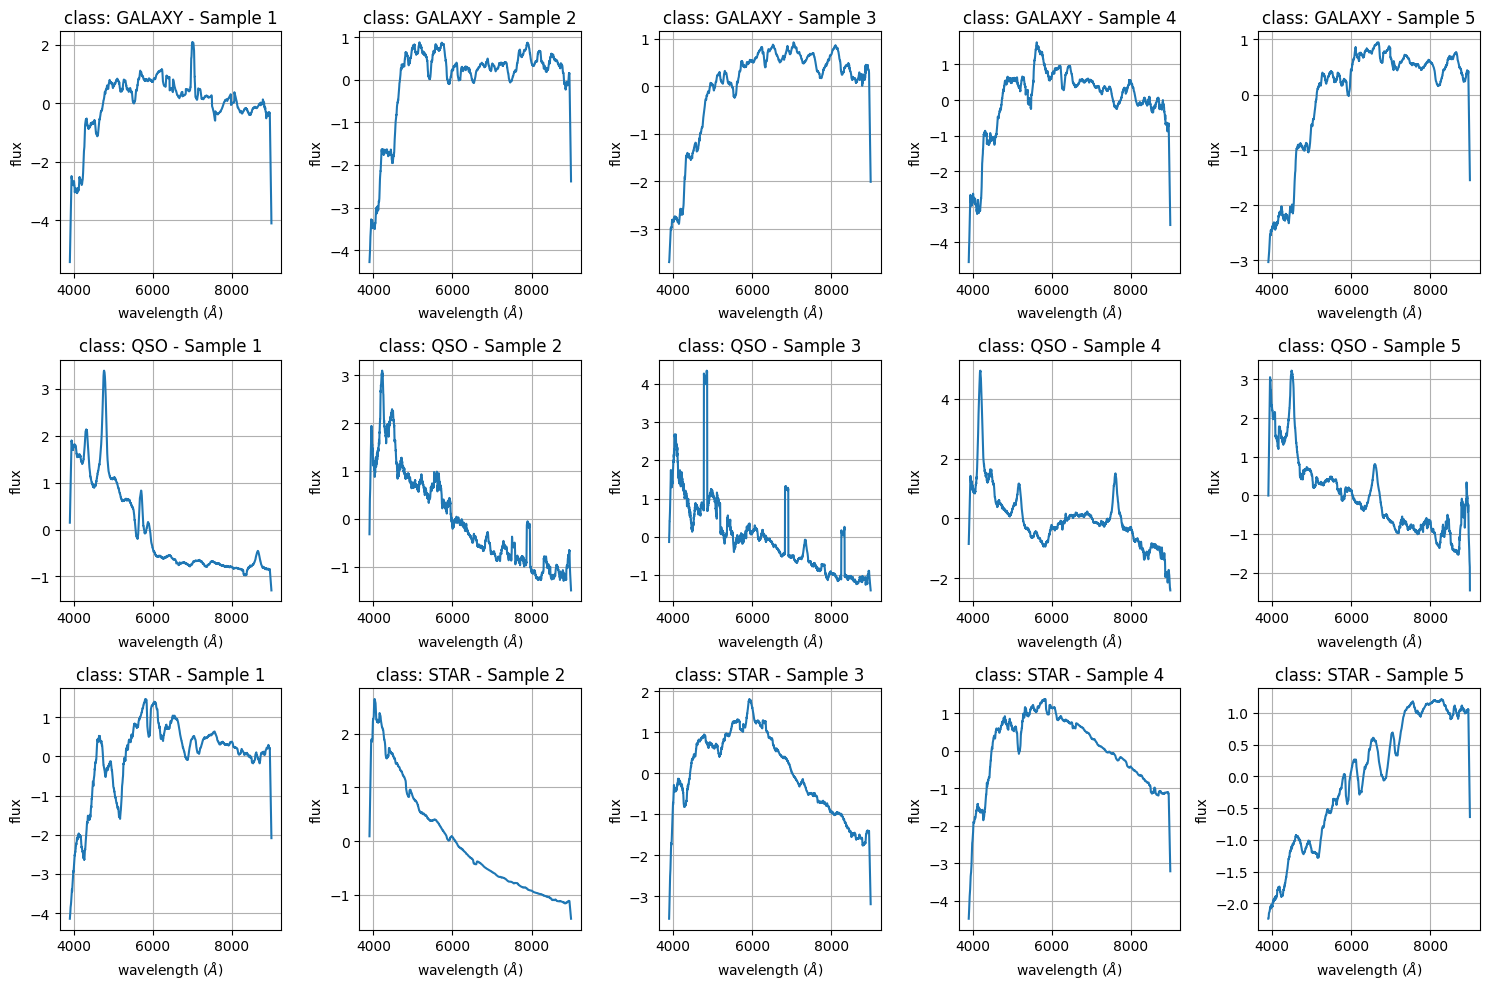

In [4]:
#检视光谱
num_samples = 5

wavelength = np.linspace(3900, 9000, 3000)  # 定义波长范围
c = {0:'GALAXY',1:'QSO',2:'STAR'}
fig, axs = plt.subplots(3, num_samples, figsize=(15, 10))  # 创建子图，3行，每类num_samples列
for label_idx in range(3):  # 遍历每个类别
    # 找到当前类别的所有索引
    indices = np.where(labels == label_idx)[0]
    # 从这些索引中随机选择 num_samples 个
    chosen_indices = np.random.choice(indices, num_samples, replace=False)

    for plot_idx, ax in enumerate(axs[label_idx]):
        # 获取对应样本的流量数据
        selected_flux = flux_scaled[chosen_indices[plot_idx]]

        # 绘图
        ax.plot(wavelength, selected_flux)
        ax.set_title(f'class: {c[label_idx]} - Sample {plot_idx+1}')
        ax.set_xlabel('wavelength ($\AA$)')
        ax.set_ylabel('flux')
        ax.grid(True)

plt.tight_layout()
plt.show()

In [4]:
counts = np.bincount(labels)

for label in range(len(counts)):
    print(f"Label {label} 出现了 {counts[label]} 次")

Label 0 出现了 3427 次
Label 1 出现了 1011 次
Label 2 出现了 95562 次


In [7]:
#根据数据数量添加权重
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
class_weights_dict

{0: 9.726680284019064, 1: 32.97065611605671, 2: 0.3488136846584765}

In [8]:
from keras import utils

labels = utils.to_categorical(labels, 3)
labels = labels.astype(np.float32)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_data, train_labels, test_data, test_labels = flux_scaled[train_idx], labels[train_idx], flux_scaled[test_idx], labels[test_idx]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(3000, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, class_weight=class_weights_dict, epochs=3, validation_data=(test_data, test_labels))

Epoch 1/3
2813/2813 [==============================] - 829s 294ms/step - loss: 0.2673 - accuracy: 0.8945 - val_loss: 0.1147 - val_accuracy: 0.9577
Epoch 2/3
2813/2813 [==============================] - 834s 297ms/step - loss: 0.2290 - accuracy: 0.9067 - val_loss: 0.1462 - val_accuracy: 0.9535
Epoch 3/3
2813/2813 [==============================] - 827s 294ms/step - loss: 0.2146 - accuracy: 0.9129 - val_loss: 0.1656 - val_accuracy: 0.9421


In [29]:
model.save('drive/MyDrive/lamost6weights.keras')

-------------------
**show confusion_matrix**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [5]:
from tensorflow.keras.models import load_model
model = load_model('drive/MyDrive/lamost6weights.keras')

In [26]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

313/313 [==============================] - 21s 66ms/step


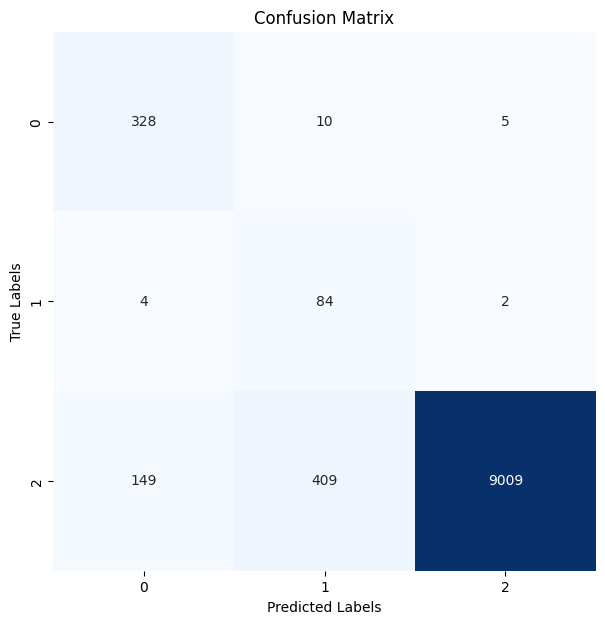

In [27]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

-----------
**Predict test_data.fits**

In [2]:
from tensorflow.keras.models import load_model
model = load_model('drive/MyDrive/lamost6weights.keras')

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [13]:
test_hdulist = fits.open('drive/MyDrive/test_data.fits')
test_flux = test_hdulist[0].data
test_objid = test_hdulist[1].data['objid']

In [16]:
test_flux [test_flux < 0 ] = 0


# 定义移动平均函数
def moving_average(data, window_size):
    """计算数据的移动平均值"""
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

window_size = 50

# 移动平均
test_flux_smooth = np.apply_along_axis(moving_average, 1, test_flux, window_size)


In [17]:
from sklearn.preprocessing import StandardScaler
import numpy as np

test_flux_scaled = np.zeros_like(test_flux)

scaler = StandardScaler()
#StandardScaler正则化
for i in range(flux.shape[0]):
    test_flux_scaled[i, :] = scaler.fit_transform(test_flux_smooth[i, :].reshape(-1, 1)).flatten()

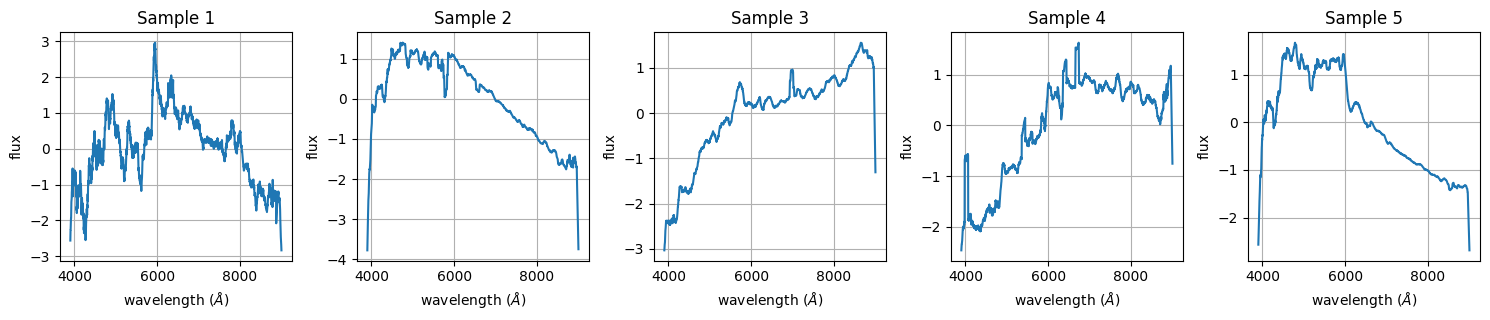

In [34]:
#检视正则化光谱

import pylab as plt

num_samples = 5

wavelength = np.linspace(3900, 9000, 3000)  # 定义波长范围
fig, axs = plt.subplots(1, num_samples, figsize=(15, 3.3))  # 创建子图


for plot_idx, ax in enumerate(axs):
    chosen_index = np.random.randint(0, len(test_flux_scaled))

    # 获取对应样本的流量数据
    selected_flux = test_flux_scaled[chosen_index]

    # 绘图
    ax.plot(wavelength, selected_flux)
    ax.set_title(f'Sample {plot_idx+1}')
    ax.set_xlabel('wavelength ($\AA$)')
    ax.set_ylabel('flux')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [36]:
test_predictions = model.predict(test_flux_scaled)
test_predicted_labels = np.argmax(test_predictions, axis=1)

32/32 [==============================] - 2s 60ms/step


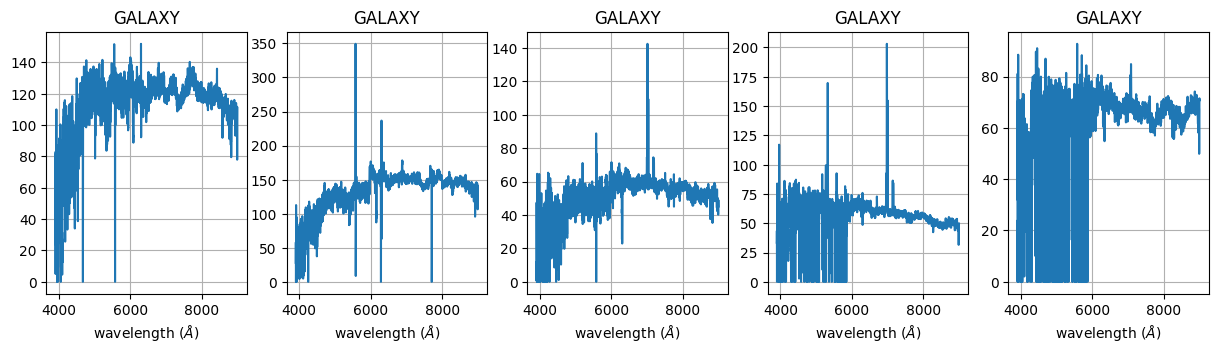

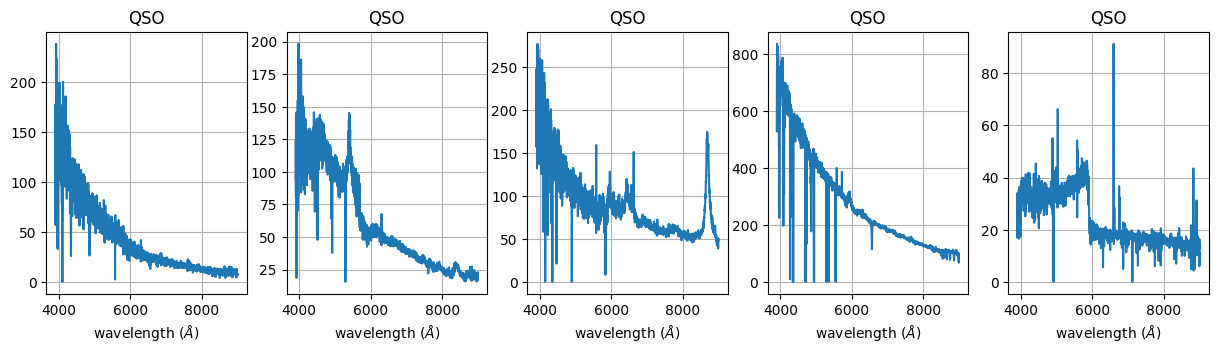

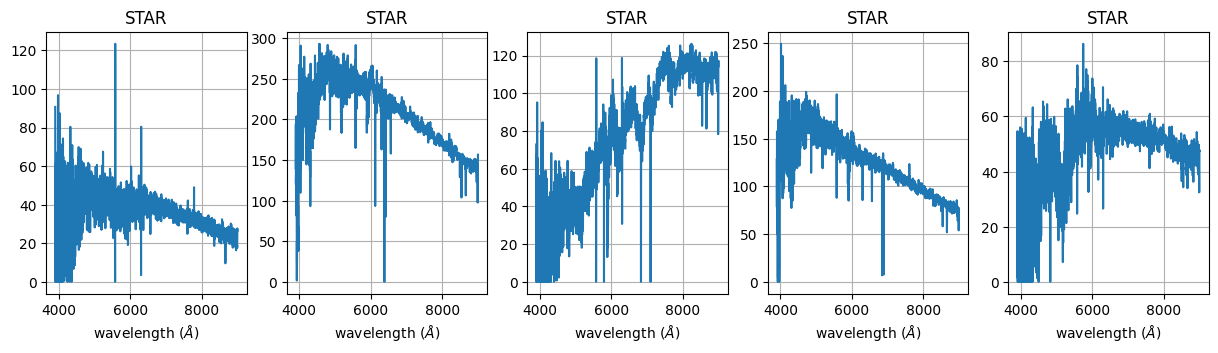

In [42]:
# 展示分类结果
c = {0:'GALAXY',1:'QSO',2:'STAR'}

for j in range(3):
  class_indices = np.where(test_predicted_labels == j)[0]
  fig, axes = plt.subplots(1, 5, figsize=(15, 3.4))
  for i, ax in enumerate(axes):
      if i < len(class_indices):
          spec_index = class_indices[i]
          ax.plot(wavelength,test_flux[spec_index])
          ax.set_title(f"{c[j]}")
          ax.set_xlabel('wavelength ($\AA$)')

          ax.grid(True)

  plt.show()


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2998, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1499, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1497, 128)         24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 748, 128)          0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 95744)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [46]:
import pandas as pd

data = {
    'obj_id': test_objid,
    'predicted_label': test_predicted_labels
}
df = pd.DataFrame(data)

df.to_csv('predicted_labels.csv', index=False)
